In [1]:
%pip install agentpy GPy GPyOpt emukit ase scikit-optimize

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Model Design
import agentpy as ap 
import pandas as pd
from boids_model import BoidsModel

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as cp
import random
from sklearn.model_selection import train_test_split

import ase.io
from ase.io import read, write
from ase import Atoms, Atom
from ase import units
from ase.build import molecule
from ase.md.langevin import Langevin
from ase.io.trajectory import Trajectory

import GPy
import GPyOpt
import emukit
from emukit.core import ContinuousParameter, ParameterSpace, DiscreteParameter
from emukit.core.initial_designs import RandomDesign
# from emukit.core.initial_designs.latin_design import LatinDesign
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
from emukit.bayesian_optimization.acquisitions import ExpectedImprovement
from emukit.bayesian_optimization.loops import BayesianOptimizationLoop
from emukit.core.loop import UserFunctionResult
from emukit.core.loop import OuterLoop

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from skopt.space import Real
from sklearn.metrics import mean_squared_error

In [37]:
results = ap.DataDict.load(exp_name='BoidsModel', exp_id=3)

Loading from directory ap_output/BoidsModel_3/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading variables_BoidsModel.csv - Successful
Loading parameters_log.json - Successful


In [40]:
# X = results.reporters[['final_alignment', 'final_cohesion', 'final_separation_std', 'cohesion_separation_ratio', 'final_border_distance_median', 'flock_density']]
X = results.reporters[['cohesion_separation_ratio', 'final_border_distance_median', 'flock_density']]
Y =  results.reporters[['cohesion_strength', 'seperation_strength', 'alignment_strength', 'border_strength']]

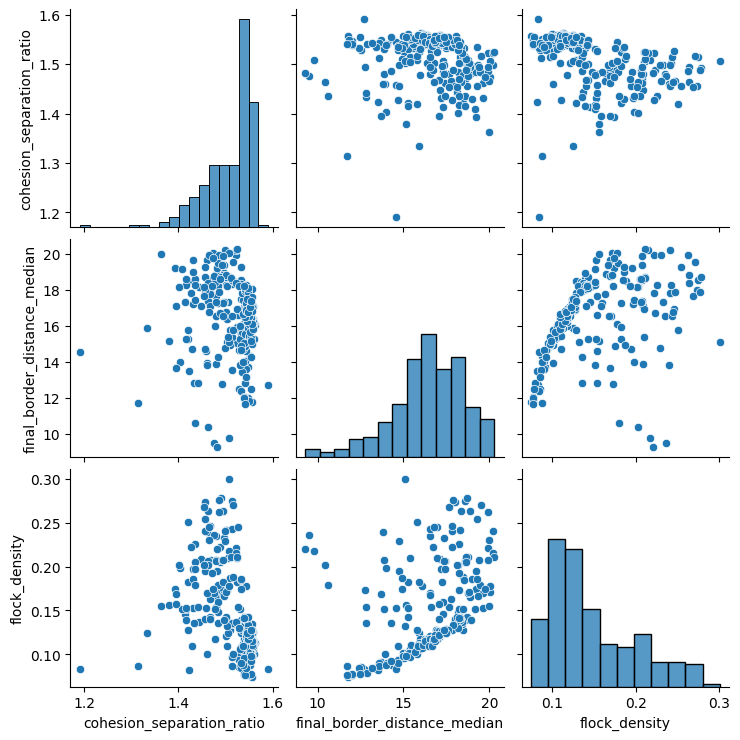

In [41]:
import seaborn as sns

sns.pairplot(X)

In [24]:
correlation_matrix = X.corr()
print(correlation_matrix)

                           final_alignment  final_cohesion  \
final_alignment                   1.000000       -0.039036   
final_cohesion                   -0.039036        1.000000   
final_separation_avg             -0.040331        0.999840   
final_border_distance_avg         0.060430       -0.998578   

                           final_separation_avg  final_border_distance_avg  
final_alignment                       -0.040331                   0.060430  
final_cohesion                         0.999840                  -0.998578  
final_separation_avg                   1.000000                  -0.998196  
final_border_distance_avg             -0.998196                   1.000000  


In [42]:
X = X.values.tolist()
Y = Y.values.tolist()

# Shuffle the trajectory indices for a random split
indices = list(range(len(X)))
random.shuffle(indices)

# Split indices for training and validation
split_index = int(len(indices) * 0.8)  # 80-20 split, for example
train_indices = indices[:split_index]
validate_indices = indices[split_index:]

# Include isolated atoms in both datasets
# train_atoms = [out_traj[i] for i in train_indices] + [isolated_H, isolated_O]
X_train, X_val = np.array([X[i] for i in train_indices]), np.array([X[i] for i in validate_indices])
Y_train, Y_val = np.array([Y[i] for i in train_indices]), np.array([Y[i] for i in validate_indices])
X_all, Y_all = np.array(X), np.array(Y)

In [43]:
from sklearn.preprocessing import StandardScaler

# Initialize scalers for X and Y
scaler_X = StandardScaler()
scaler_Y = StandardScaler()

# Fit and transform the training data
X_train, Y_train = scaler_X.fit_transform(X_train), scaler_Y.fit_transform(Y_train)

# Transform the validation and test data
X_val, Y_val = scaler_X.transform(X_val), scaler_Y.transform(Y_val)

In [44]:
print(Y_train)

[[ 0.22323811  1.44940622  1.38023339  1.33482048]
 [ 1.547092    1.44940622  1.38023339  0.43315367]
 [ 1.547092   -0.78002917 -1.3358529   0.43315367]
 [ 0.22323811 -0.78002917  0.4748713   1.33482048]
 [ 1.547092    1.44940622  0.4748713  -1.37017997]
 [ 1.547092    0.33468852 -0.4304908  -1.37017997]
 [ 1.547092    1.44940622 -1.3358529   0.43315367]
 [-0.83584501  0.33468852  0.4748713  -0.46851315]
 [ 1.547092   -1.05870859 -1.3358529   1.33482048]
 [-0.83584501 -1.05870859  1.38023339  1.33482048]
 [ 1.547092   -0.78002917 -1.3358529   1.33482048]
 [-0.83584501  1.44940622  0.4748713  -0.46851315]
 [ 1.547092   -1.05870859  0.4748713   0.43315367]
 [ 0.22323811  1.44940622 -0.4304908  -0.46851315]
 [-0.9682304  -0.78002917  0.4748713   1.33482048]
 [-0.9682304   0.33468852  0.4748713   1.33482048]
 [ 0.22323811 -0.78002917 -1.3358529   0.43315367]
 [-0.9682304   1.44940622 -1.3358529   0.43315367]
 [ 0.22323811 -0.78002917 -0.4304908   1.33482048]
 [ 0.22323811  0.33468852 -1.33

In [45]:
num_parameters = X_all.shape[1]

# Maximum and minimum values
max_values = X_all.max(axis=0)  # Max value for each parameter across all configurations
min_values = X_all.min(axis=0)  # Min value for each parameter across all configurations

parameters_list = []
for i in range(num_parameters):
    parameter_name = f"param_{i}"
    parameters_list.append(ContinuousParameter(parameter_name, min_values[i], max_values[i]))

# Create continuours parameter space
continuous_parameter_space = ParameterSpace(parameters_list)

In [29]:
# kernel = RBF(X_train.shape[1], (1e-2, 1e2)) 

kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) + WhiteKernel(noise_level=0.01)

gp= GaussianProcessRegressor(kernel=kernel, alpha=1e-2)
gp.fit(X_train, Y_train)

GaussianProcessRegressor(alpha=0.01,
                         kernel=1**2 * RBF(length_scale=10) + WhiteKernel(noise_level=0.01))

In [46]:
def objective_fun(params):
    # Unpack parameters
    length_scale = params[0]
    constant_value = params[1]

    # Define the kernel
    kernel = C(constant_value, (1e-3, 1e3)) * RBF(length_scale, (1e-2, 1e2))

    # Build and fit the Gaussian Process model
    gp = GaussianProcessRegressor(kernel=kernel)
    gp.fit(X_train, Y_train)
    # Negative log likelihood
    # return -gp.log_marginal_likelihood_value_

    # Make predictions on the validation data
    Y_pred = gp.predict(X_val)

    # Calculate and return MSE
    mse = mean_squared_error(Y_val, Y_pred)
    return mse

In [47]:
from skopt import gp_minimize
from skopt.space import Real, Integer

# Convert Emukit space to skopt space
skopt_space = [(param.min, param.max) for param in continuous_parameter_space.parameters]
num_evaluations = 20
result = gp_minimize(
            objective_fun,  # the function to minimize
            skopt_space,  # the bounds on each dimension of x
            acq_func="EI",  # the acquisition function
            n_calls=num_evaluations,  # the number of evaluations of f
            n_random_starts=10,  # the number of random initialization points
            random_state=123  # the random seed
        )

In [48]:
# Optimal parameters
optimal_params = result.x
print("Optimal Parameters:", optimal_params)

Optimal Parameters: [1.5078562923715082, 15.170451394549172, 0.17048308343435303]


In [49]:
# Optimal parameters obtained from gp_minimize
length_scale_optimal = optimal_params[0]
constant_value_optimal = optimal_params[1]

# Define the kernel with optimal parameters
optimal_kernel = C(constant_value_optimal, (1e-3, 1e3)) * RBF(length_scale_optimal, (1e-2, 1e2))

# Build and fit the Gaussian Process model with the optimal kernel
gp_optimal = GaussianProcessRegressor(kernel=optimal_kernel)
gp_optimal.fit(X_train, Y_train)

GaussianProcessRegressor(kernel=3.89**2 * RBF(length_scale=1.51))

In [50]:
Y_pred, sigma = gp_optimal.predict(X_val, return_std=True)
print("Predicted values: ", Y_pred[:10])
print("\nActual values: ", Y_val[:10])

Predicted values:  [[-1.23395785e-019 -1.34926747e-019  1.75903363e-019 -5.97094949e-020]
 [ 2.28666079e-002  2.11208796e-001 -1.93879341e-001  8.03407542e-002]
 [-8.44764868e-003 -6.80562438e-003 -1.16550937e-002 -1.19545916e-002]
 [ 8.40117378e-010  1.25954143e-009 -5.02724757e-009 -5.15643146e-009]
 [-1.63101904e-030 -2.06590201e-030  9.26636064e-031  2.60469060e-030]
 [-1.63044139e-006  2.79068789e-006  1.28840330e-006 -2.63814534e-006]
 [ 2.04681360e-017 -1.03198408e-017 -1.76734278e-017 -6.19846192e-018]
 [-1.03121901e-001  1.15039764e+000  5.62014841e-001  7.97515598e-001]
 [-1.58070262e-023 -1.27345119e-023 -7.02805800e-024  2.17918612e-023]
 [-1.44386236e-127 -1.34744450e-127 -7.43642013e-128 -2.36688772e-127]]

Actual values:  [[-0.83584501 -0.78002917  1.38023339  0.43315367]
 [-0.9682304   1.44940622  0.4748713   1.33482048]
 [-0.83584501 -0.78002917 -1.3358529  -1.37017997]
 [ 0.22323811  0.33468852 -0.4304908  -1.37017997]
 [ 1.547092   -1.05870859 -1.3358529  -0.46851315

In [51]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Calculate the metrics
mae = mean_absolute_error(Y_val, Y_pred)
mse = mean_squared_error(Y_val, Y_pred)
r2 = r2_score(Y_val, Y_pred)

print(f'MAE: {mae}, MSE: {mse}, R^2: {r2}')

MAE: 0.9040680164023048, MSE: 1.0429296660072187, R^2: 0.014194782494410668


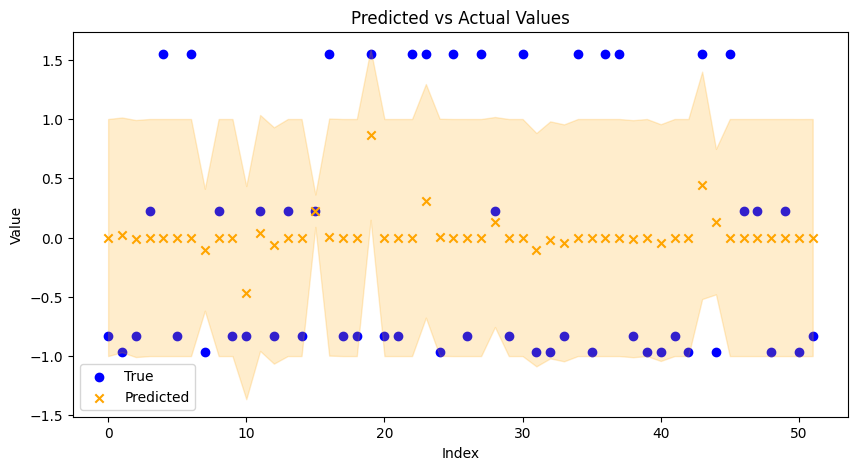

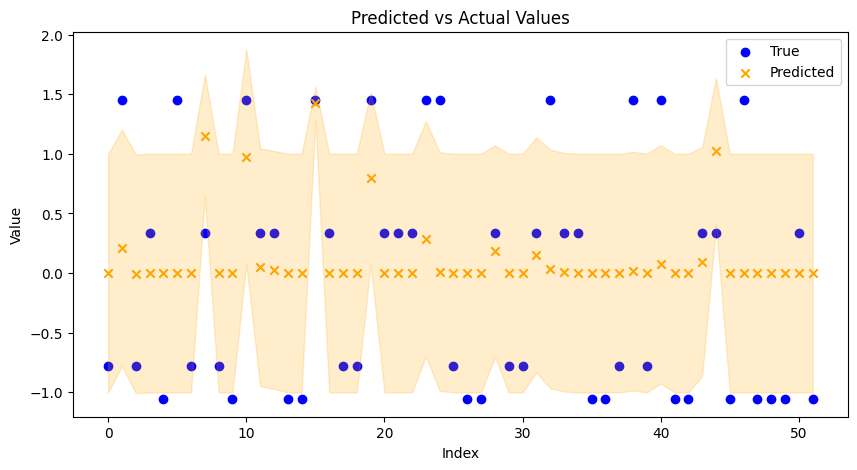

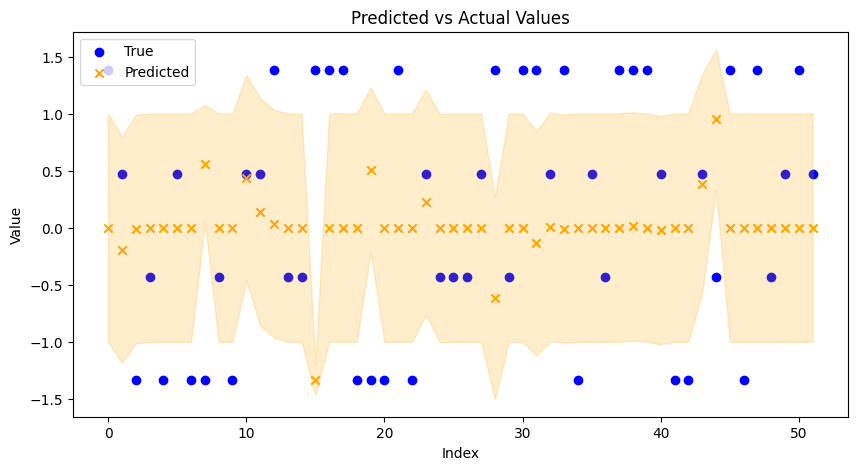

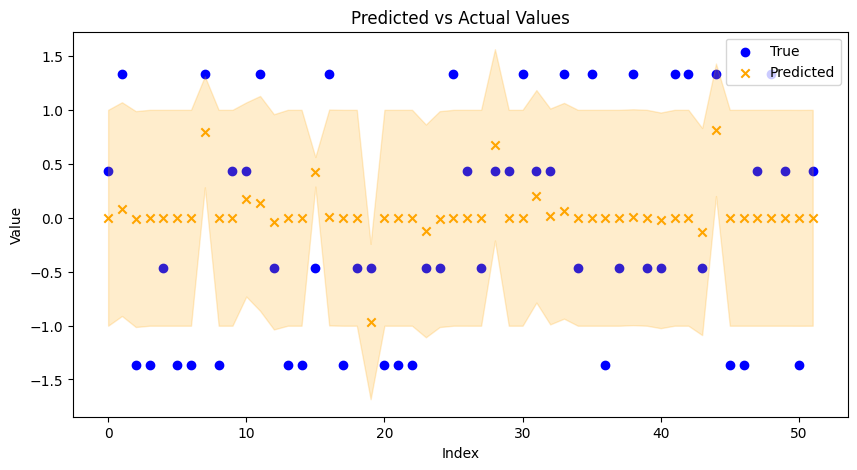

In [52]:
# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(4):
    plt.figure(figsize=(10, 5))
    plt.scatter(range(len(Y_val[:, i])), Y_val[:, i], color='blue', label='True')
    plt.scatter(range(len(Y_pred[:, i])), Y_pred[:, i], color='orange', label='Predicted', marker='x')

    # Plot the standard deviation
    plt.fill_between(range(len(Y_pred[:, i])), Y_pred[:, i] - sigma[:, i], Y_pred[:, i] + sigma[:, i], color='orange', alpha=0.2)

    plt.title('Predicted vs Actual Values')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

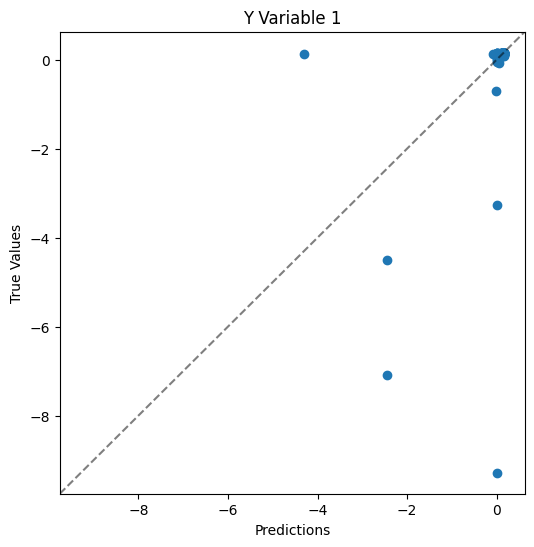

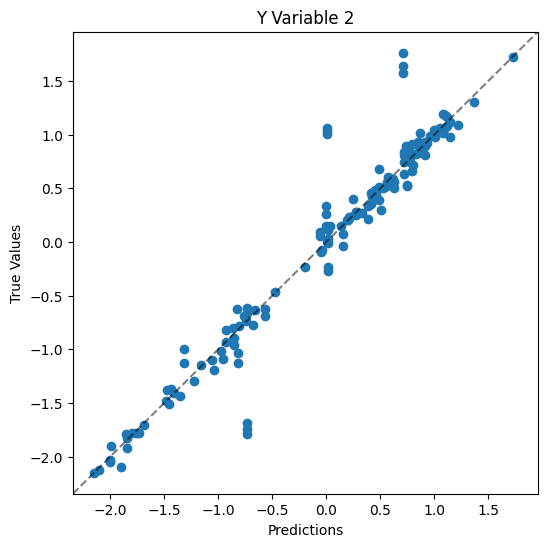

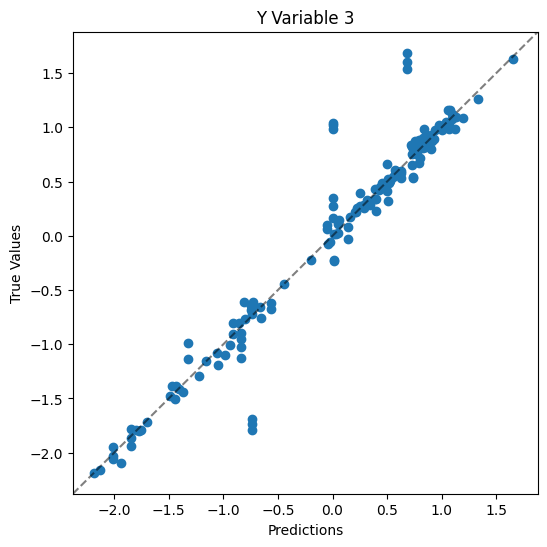

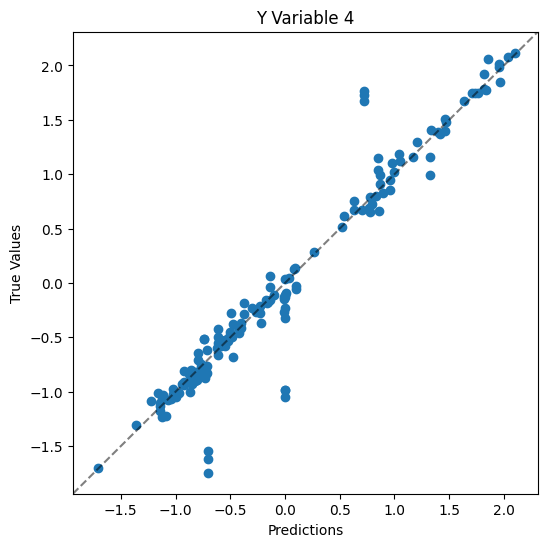

In [21]:
import matplotlib.pyplot as plt

# Assuming Y_test_np and Y_pred_np are 2D arrays with 4 columns each
for i in range(4):
    plt.figure(figsize=(6, 6))
    plt.scatter(Y_pred[:, i], Y_val[:, i])
    plt.xlabel('Predictions')
    plt.ylabel('True Values')
    plt.title(f'Y Variable {i+1}')

    # Add a diagonal line
    limits = [np.min([plt.xlim(), plt.ylim()]),  # Find the lower limit
              np.max([plt.xlim(), plt.ylim()])]  # Find the upper limit
    plt.xlim(limits)
    plt.ylim(limits)
    plt.plot(limits, limits, color='black', alpha=0.5, linestyle='--')

    plt.show()